In [20]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

## Load data sources

In [54]:
# load the list which assigns events to categories
filename_event_list = "moodle_default_events_list.xlsx"
event_list = pd.read_excel(filename_event_list, header=7)
event_list = event_list[["Event Name", "Active/Passive", "User-Agent-Based"]]
event_list = event_list.rename(columns = {"Event Name":"eventname", "Active/Passive":"activepassive", "User-Agent-Based":"useragentbased"})
event_list[:3]

,eventname,activepassive,useragentbased
0,Badge archived\n\core\event\badge_archived,22 passive,4 Student-System
1,Badge awarded\n\core\event\badge_awarded,22 passive,6 Course Relevant Actions
2,Badge created\n\core\event\badge_created,NaN,5 Others


In [8]:
# load the moodle course log
filename_course_log = 'course_log.pkl'
course_log_list = pd.read_pickle(filename_course_log)
course_log = pd.DataFrame(course_log_list)
course_log[:3]

,action,target,crud,contextlevel,edulevel,eventname,userid,role,relateduserid,courseid,timecreated
0,viewed,course,r,50,2,\core\event\course_viewed,13,norole,NaN,3,1598956500
1,viewed,user_list,r,50,0,\core\event\user_list_viewed,13,norole,NaN,3,1598956507
2,viewed,user_list,r,50,0,\core\event\user_list_viewed,13,norole,NaN,3,1598956516


## Start data handling

In [45]:
# count the occurrence of each event type
event_frequency = course_log.groupby(["eventname"]).count()
event_frequency = event_frequency.drop(labels=[c for c in event_frequency.columns[1:]], axis="columns")
event_frequency = event_frequency.rename(columns = {"action":"count"})
event_frequency = event_frequency.reset_index()
event_frequency

,eventname,count
0,\assignsubmission_file\event\assessable_uploaded,33
1,\assignsubmission_file\event\submission_created,29
2,\assignsubmission_file\event\submission_updated,4
3,\assignsubmission_onlinetext\event\assessable_...,47
4,\assignsubmission_onlinetext\event\submission_...,41
...,...,...
67,\mod_workshop\event\submission_reassessed,108
68,\mod_workshop\event\submission_updated,82
69,\mod_workshop\event\submission_viewed,559
70,\tool_recyclebin\event\course_bin_item_created,49


In [72]:
# map events with interaction categories
overview = event_frequency.join(event_list, rsuffix="_ef").drop("eventname_ef", axis='columns')
overview

,eventname,count,activepassive,useragentbased
0,\assignsubmission_file\event\assessable_uploaded,33,22 passive,4 Student-System
1,\assignsubmission_file\event\submission_created,29,22 passive,6 Course Relevant Actions
2,\assignsubmission_file\event\submission_updated,4,NaN,5 Others
3,\assignsubmission_onlinetext\event\assessable_...,47,NaN,5 Others
4,\assignsubmission_onlinetext\event\submission_...,41,NaN,5 Others
...,...,...,...,...
67,\mod_workshop\event\submission_reassessed,108,22 passive,2 Student-Teacher
68,\mod_workshop\event\submission_updated,82,22 passive,2 Student-Teacher
69,\mod_workshop\event\submission_viewed,559,22 passive,2 Student-Teacher
70,\tool_recyclebin\event\course_bin_item_created,49,11 active,6 Course Relevant Actions


<BarContainer object of 5 artists>

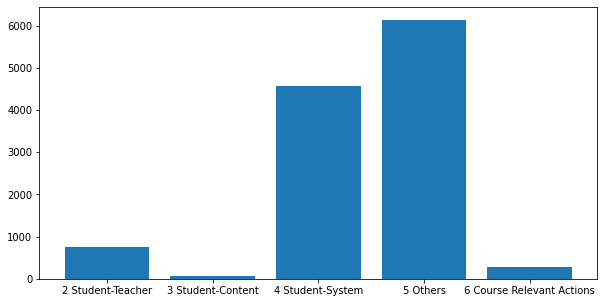

In [86]:
user_agent_based = overview.groupby("useragentbased").sum()["count"]
plt.figure(figsize=(10,5))
plt.bar(user_agent_based.index, user_agent_based)

<BarContainer object of 2 artists>

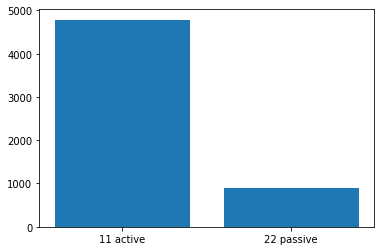

In [88]:
active_passive = overview.groupby("activepassive").sum()["count"]
plt.bar(active_passive.index, active_passive)